In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
family = pd.DataFrame(pd.read_csv("./Family_Income_and_Expenditure.csv"))
family.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


In [39]:
compositional_cols = ['Total Food Expenditure', 'Medical Care Expenditure', 'Education Expenditure']

family = family[['Total Food Expenditure', 'Medical Care Expenditure', 'Education Expenditure', 'Total Household Income']]
total_household_income = family['Total Household Income']
#family = family[(family != 0).all(axis=1)]

# Tách dữ liệu thành phần và biến mục tiêu
compositional_data = family[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()

,Total Food Expenditure,Medical Care Expenditure,Education Expenditure
0,0.748218,0.021949,0.229834
1,0.673712,0.034995,0.291293
2,0.992029,0.001127,0.006843
3,0.995417,0.000764,0.003819
4,0.998523,0.001477,0.000000


In [40]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, total_household_income, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                      Robust linear Model Regression Results                      
Dep. Variable:     Total Household Income   No. Observations:                33235
Model:                                RLM   Df Residuals:                    33232
Method:                              IRLS   Df Model:                            2
Norm:                              HuberT                                         
Scale Est.:                           mad                                         
Cov Type:                              H1                                         
Date:                    Tue, 21 May 2024                                         
Time:                            14:27:11                                         
No. Iterations:                         8                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [41]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 268680.7535822444


In [42]:
# Độ lệch chuẩn của Total.Household.Income
std_income = np.std(y_test)
print(f"Standard Deviation of Total Household Income: {std_income}")

Standard Deviation of Total Household Income: 269205.7592615033


/tmp/ipykernel_31025/12606955.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')


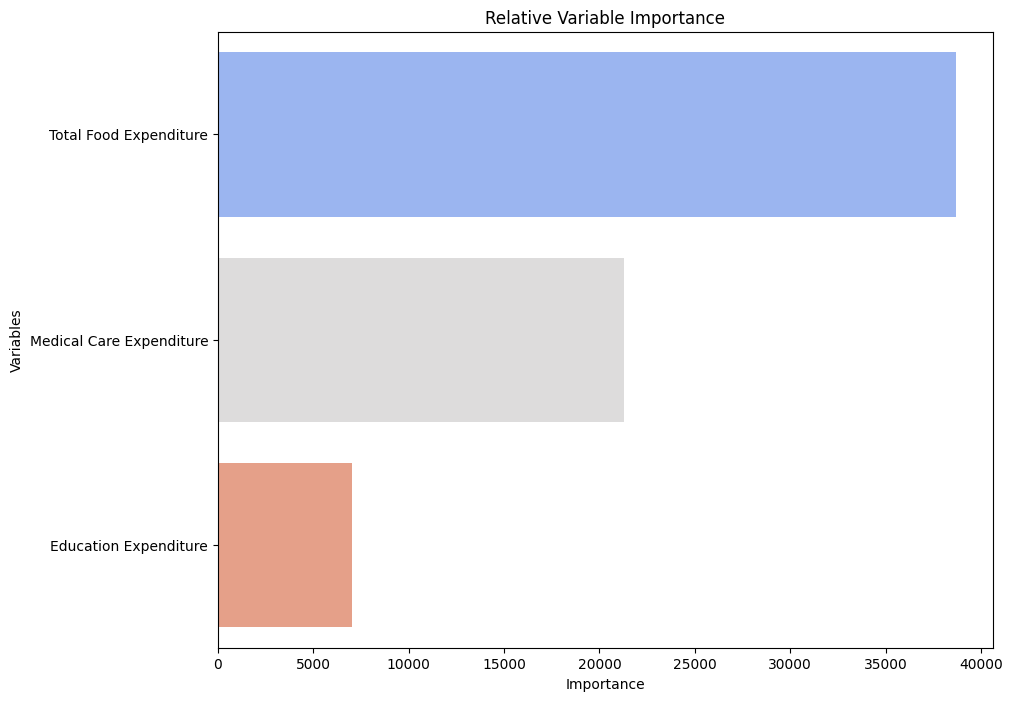

In [43]:
# Vẽ biểu đồ tầm quan trọng của biến
importance = rlm_results.params[1:]
variables = X_train.columns

importance_df = pd.DataFrame({
    'Variables': variables,
    'Importance': np.abs(importance)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')
plt.title('Relative Variable Importance')
plt.show()


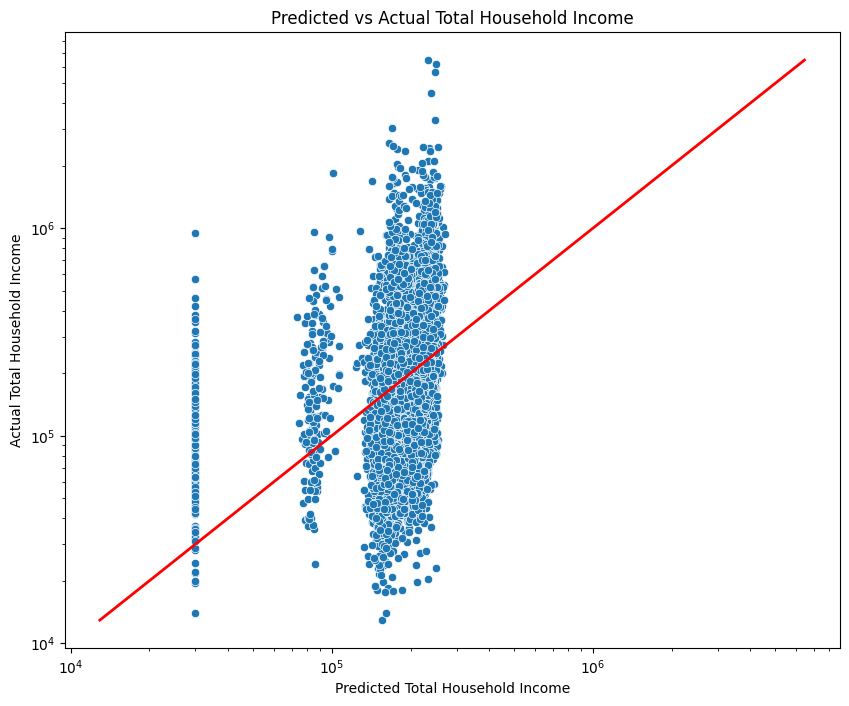

In [44]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total Household Income')
plt.ylabel('Actual Total Household Income')
plt.title('Predicted vs Actual Total Household Income')
plt.show()

In [45]:
# Tính toán lỗi
error = pred - y_test

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE:", rmse)

NameError: name 'pred' is not defined

Kích thước của mảng: (8309,)
Kích thước của mảng: (8309,)


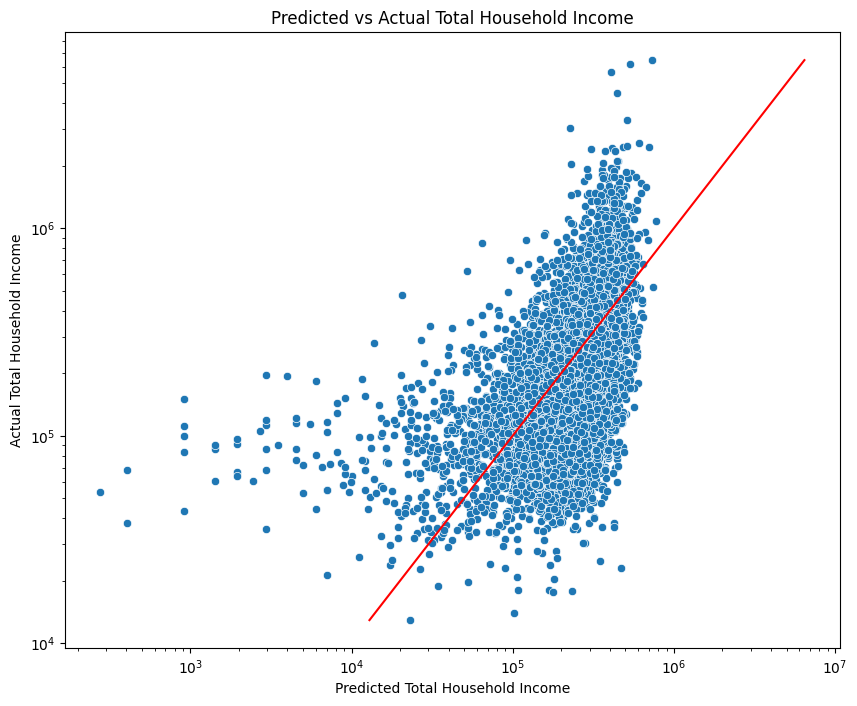

In [ ]:
print("Kích thước của mảng:", pred.shape)
print("Kích thước của mảng:", y_test.shape)

# Plot the predictions (on the x-axis) against the outcome (cty) on the test data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total Household Income')
plt.ylabel('Actual Total Household Income')
plt.title('Predicted vs Actual Total Household Income')
plt.show()